In [1]:
import numpy as np
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
import keras
from keras.layers import *
from keras import Model 
import matplotlib.pyplot as plt
%matplotlib inline

/home/mcicek/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def scale(arr):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(arr)
    # normalize the dataset and printscaler, 
    normalized = scaler.transform(arr)
    return normalized 

In [3]:
def reshaper(m, l, timesteps = 1):
    wasted = (m.shape[0] % timesteps)
    m, l = m[wasted:], l[wasted:]
    l = scale(l)
    m = m.reshape((int(m.shape[0]/timesteps), timesteps, m.shape[1], m.shape[2], m.shape[3]))
    l = l.reshape((int(l.shape[0]/timesteps), timesteps, l.shape[1]))
    l = l[:, -1, :]
    return m, l

In [4]:
num_datasets = 2

In [5]:
from DatasetHandler.BiwiBrowser import *
biwi = readBIWIDataset(subjectList = [s for s in range(1, num_datasets+1)])#

Frames from /home/mcicek/Datasets/HeadPoses/biwi/hpdb/ have been started to read by 2018-12-23 02:31:58.227390
Subject 01's frames have been started to read 2018-12-23 02:31:58.228229
Subject 01's all frames have been read by 2018-12-23 02:31:58.228250
Subject 02's frames have been started to read 2018-12-23 02:31:58.229022
Subject 02's all frames have been read by 2018-12-23 02:31:58.229039
/home/mcicek/Datasets/HeadPoses/biwi/db_annotations.tgz has been started to read by 2018-12-23 02:31:58.229050
2 annotations have been read by 2018-12-23 02:31:59.355168


In [6]:
num_outputs = 1

In [7]:
timesteps = 5

In [8]:
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from sklearn.preprocessing import MinMaxScaler

In [9]:
keras.backend.clear_session()
def getFinalModel(num_outputs = num_outputs):
    dense_layer_1 = 1#int((patch_size[0] * patch_size[1]) / 1)0010#00000
    dense_layer_2 = 8
    inp = BIWI_Frame_Shape
    rnn = Sequential()
    rnn.add(TimeDistributed(Conv2D(8, 3, 3, input_shape=inp, border_mode='same', activation='relu', W_constraint=maxnorm(3)), input_shape=(timesteps, inp[0], inp[1], inp[2])))
    rnn.add(TimeDistributed(Dropout(0.2)))
    rnn.add(TimeDistributed(Conv2D(8, 3, 3, activation='relu', border_mode='same', W_constraint=maxnorm(3))))
    rnn.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    
    #rnn.add(TimeDistributed(vgg_model, input_shape=(timesteps, inp[0], inp[1], inp[2])))# batch_size = timesteps,
    #vgg_model.layers.pop()
    #vgg_model.layers.pop()
    rnn.add(TimeDistributed(Flatten()))
    rnn.add(LSTM(15)) # , stateful=True, activation='relu'
    rnn.add(Dense(num_outputs))

    for layer in rnn.layers[:15]:
        layer.trainable = False
    rnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return rnn

In [10]:
full_model = getFinalModel(num_outputs = num_outputs)

/home/mcicek/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), input_shape=(480, 640,..., activation="relu", padding="same", kernel_constraint=<keras.con...)`
  import sys
/home/mcicek/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), activation="relu", padding="same", kernel_constraint=<keras.con...)`
  if __name__ == '__main__':


In [11]:
c = 0
frames, labelsList = [], []
for inputMatrix, labels in biwi:
    inputMatrix, labels = reshaper(inputMatrix, labels, timesteps = timesteps)
    if c < num_datasets-1:
        full_model.fit(inputMatrix, labels[:, :num_outputs], batch_size = timesteps, epochs=1, verbose=2) #, shuffle=False
        #full_model.reset_states()
    else:
        frames.append(inputMatrix)
        labelsList.append(scale(labels))
    c += 1
    print('Batch %d done!' % c)

Epoch 1/1
 - 5s - loss: 0.9161 - mean_absolute_error: 0.7603
Batch 1 done!
Batch 2 done!


In [12]:
test_inputMatrix, test_labels = frames[0], labelsList[0]

In [13]:
predictions = full_model.predict(test_inputMatrix, batch_size = timesteps)

In [14]:
output1 = numpy.concatenate((test_labels[:, :1], predictions[:, :1]), axis=1)

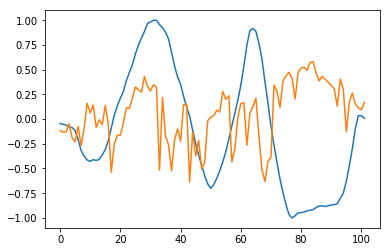

In [15]:
plt.plot(output1)

In [ ]:
output1 = numpy.concatenate((test_labels[:, :1], predictions[:, :1]), axis=1)
output2 = numpy.concatenate((test_labels[:, 1:2], predictions[:, 1:2]), axis=1)
output3 = numpy.concatenate((test_labels[:, 2:3], predictions[:, 2:3]), axis=1)

In [ ]:
# Three subplots sharing both x/y axes
f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
ax1.plot(output1)
ax1.set_title('Sharing both axes')
ax2.plot(output2)
ax3.plot(output3)
# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)